In [378]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [379]:
# Функция бли визуализации матрицы ошибок
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img


# Функция для рассчета метрик и дохода
def use_metrics(y_test, pred, labels=None):
    if labels is None:
        labels = [0, 1]
    print(f"accuracy: {accuracy_score(y_test, pred)}")
    print(f"precision: {precision_score(y_test, pred)}")
    print(f"recall: {recall_score(y_test, pred)}")
    print(f"F-measure: {f1_score(y_test, pred)}")
    print(classification_report(y_test, pred))
    # matrix = np.rot90(np.rot90(confusion_matrix(y_test, pred), -1), -1)
    matrix = confusion_matrix(y_test, pred)
    income = matrix[1,1] * (20 - 1 - 9) - matrix[0,1] * 1
    print(f"Доход: {income}")
    scores_image = heatmap(
        matrix, xlabel='Спрогнозированная метка класса',
        ylabel='Фактическая метка класса', xticklabels=labels,
        yticklabels=labels, cmap=plt.cm.gray_r, fmt="%d"
    )
    plt.title("Матрица ошибок")
    plt.gca().invert_yaxis()

In [380]:
def calculate_income(y_test, pred, CM, CR, R):
    matrix = np.rot90(np.rot90(confusion_matrix(y_test, pred), -1), -1)
    TP = matrix[1,1]
    FP = matrix[0,1]
    return TP * (R - CM - CR) - FP * CM
    

# Загрузка и предварительная обработка данных

In [381]:
df = pd.read_csv('responses_train.txt', sep='\t', encoding='1251', decimal=',')

In [382]:
df.columns

Index(['Код клиента', 'Возраст', 'Пол', 'Сколько лет клиент',
       'Количество позиций товаров', 'Доход с клиента, тыс. ед.',
       'Общее число покупок', 'Обращений в службу поддержки',
       'Задержки платежей', 'Дисконтная карта', 'Дата отклика', 'Отклик'],
      dtype='object')

In [383]:
sex_encoder = LabelEncoder()
sex_encoder.fit(df['Пол'])
df['binary_sex'] = sex_encoder.transform(df['Пол'])

In [384]:
no_use = ['Код клиента', 'Дата отклика', 'Пол', 'Отклик',
          'Обращений в службу поддержки', 'Задержки платежей', 
          'Дисконтная карта', 'binary_sex', 'Возраст'
]
target = 'Отклик'
features = [i for i in df if i not in no_use]

# Обучение на исходных данных в условиях преобладания отрицательного класса 

In [385]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=42)

## Дерево решений

accuracy: 0.9264560710760118
precision: 0.9222222222222223
recall: 0.5514950166112956
F-measure: 0.6902286902286902
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1725
           1       0.92      0.55      0.69       301

    accuracy                           0.93      2026
   macro avg       0.92      0.77      0.82      2026
weighted avg       0.93      0.93      0.92      2026

Доход: 1646


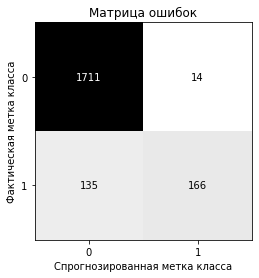

In [386]:
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
use_metrics(y_test, tree_pred)

## Случайный лес

accuracy: 0.9274432379072063
precision: 0.9139784946236559
recall: 0.5647840531561462
F-measure: 0.6981519507186857
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1725
           1       0.91      0.56      0.70       301

    accuracy                           0.93      2026
   macro avg       0.92      0.78      0.83      2026
weighted avg       0.93      0.93      0.92      2026

Доход: 1684


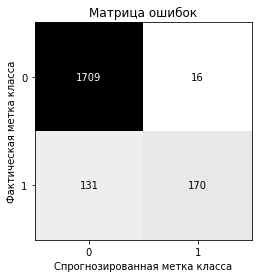

In [387]:
forest = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=0)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)
use_metrics(y_test, forest_pred)

## Логистическая регрессия

In [388]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

accuracy: 0.8948667324777887
precision: 0.7558139534883721
recall: 0.4318936877076412
F-measure: 0.5496828752642706
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1725
           1       0.76      0.43      0.55       301

    accuracy                           0.89      2026
   macro avg       0.83      0.70      0.75      2026
weighted avg       0.89      0.89      0.88      2026

Доход: 1258


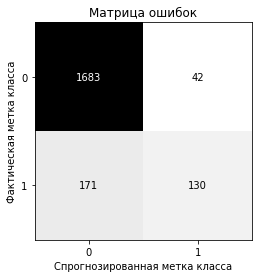

In [389]:
logreg = LogisticRegression(solver='lbfgs', random_state=0, max_iter=200)
logreg.fit(X_train_scaled, y_train)
pred = logreg.predict(X_test_scaled)
use_metrics(y_test, pred)

# Over Sampling

In [390]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=42, test_size=0.25)
X_train_samples = X_train[X_train.index.isin(y_train[y_train == 1].index )]
X_train = pd.concat(sum(([X_train], [X_train_samples] * 6), []))
y_train = pd.concat(sum(([y_train], [y_train[y_train == 1]] * 6), []))

## Дерево решений

accuracy: 0.7408687068114511
precision: 0.35964912280701755
recall: 0.9534883720930233
F-measure: 0.5222929936305734
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1725
           1       0.36      0.95      0.52       301

    accuracy                           0.74      2026
   macro avg       0.67      0.83      0.67      2026
weighted avg       0.90      0.74      0.78      2026

Доход: 2359


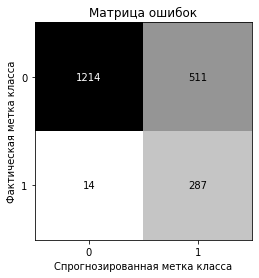

In [391]:
tree = DecisionTreeClassifier(max_depth=5, random_state=0, criterion='entropy')
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
use_metrics(y_test, tree_pred)

## Случайный лес

accuracy: 0.7413622902270484
precision: 0.3618339529120198
recall: 0.9700996677740864
F-measure: 0.5270758122743682
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1725
           1       0.36      0.97      0.53       301

    accuracy                           0.74      2026
   macro avg       0.68      0.84      0.67      2026
weighted avg       0.90      0.74      0.78      2026

Доход: 2405


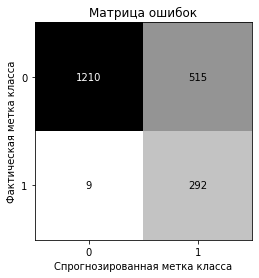

In [392]:
forest = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)
use_metrics(y_test, forest_pred)

In [393]:
for i, j in zip(features, forest.feature_importances_):
    print(i, j)

Сколько лет клиент 0.028317975357788464
Количество позиций товаров 0.4133190922981898
Доход с клиента, тыс. ед. 0.343743053090961
Общее число покупок 0.21461987925306067


## Логистическая регрессия

In [394]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

accuracy: 0.792694965449161
precision: 0.40418679549114334
recall: 0.8338870431893688
F-measure: 0.544468546637744
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1725
           1       0.40      0.83      0.54       301

    accuracy                           0.79      2026
   macro avg       0.68      0.81      0.71      2026
weighted avg       0.88      0.79      0.82      2026

Доход: 2140


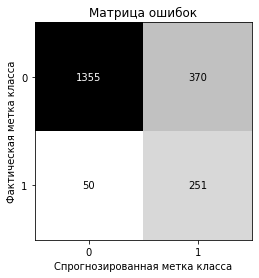

In [395]:
logreg = LogisticRegression(solver='lbfgs', random_state=0, C = 0.01, max_iter=200)
logreg.fit(X_train_scaled, y_train)
pred = logreg.predict(X_test_scaled)
use_metrics(y_test, pred)

# Тестирование на отложенной выборке

In [396]:
df_test = pd.read_csv('responses_test.txt', sep='\t', encoding='1251', decimal=',')

In [397]:
df_test['binary_sex'] = sex_encoder.transform(df_test['Пол'])

## Дерево решений

accuracy: 0.7445390596075527
precision: 0.35731300619342543
recall: 0.9603072983354674
F-measure: 0.5208333333333334
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      4621
           1       0.36      0.96      0.52       781

    accuracy                           0.74      5402
   macro avg       0.67      0.83      0.67      5402
weighted avg       0.90      0.74      0.78      5402

Доход: 6151


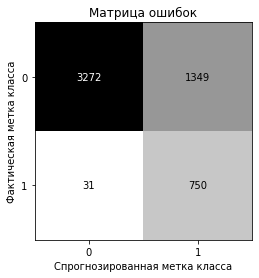

In [398]:
tree_pred = tree.predict(df_test[features])
use_metrics(df_test[target], tree_pred)

## Случайный лес

accuracy: 0.7428730099962977
precision: 0.3567389255419416
recall: 0.969270166453265
F-measure: 0.5215294522907338
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      4621
           1       0.36      0.97      0.52       781

    accuracy                           0.74      5402
   macro avg       0.67      0.84      0.67      5402
weighted avg       0.90      0.74      0.78      5402

Доход: 6205


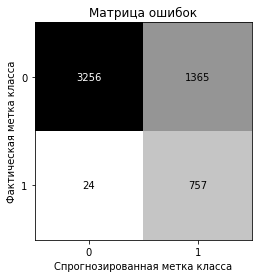

In [399]:
forest_pred = forest.predict(df_test[features])
use_metrics(df_test[target], forest_pred)

## Логистическая регрессия 

In [400]:
scaler = MinMaxScaler()
scaler.fit(df_test[features])
X_test_scaled = scaler.transform(df_test[features])

accuracy: 0.787115883006294
precision: 0.3871559633027523
recall: 0.8104993597951344
F-measure: 0.5240066225165563
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      4621
           1       0.39      0.81      0.52       781

    accuracy                           0.79      5402
   macro avg       0.67      0.80      0.69      5402
weighted avg       0.88      0.79      0.81      5402

Доход: 5328


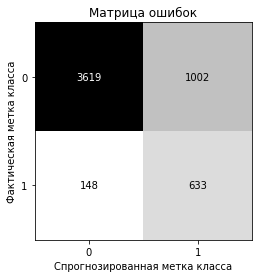

In [401]:
pred = logreg.predict(X_test_scaled)
use_metrics(df_test[target], pred)

In [ ]:
df

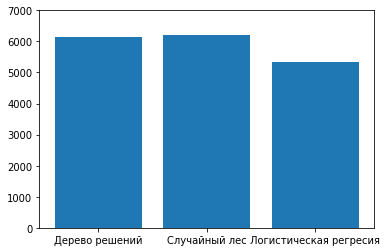

In [456]:
plt.bar(np.arange(3), [6151, 6205, 5328])
plt.axis(ymin=0, ymax=7000)
plt.xticks(x, ('Дерево решений', 'Случайный лес', 'Логистическая регресия'))
plt.show()

In [448]:
plt.axis?